## Comparing PDBBind (v2019) and BindingMOAD 2020

In [69]:
import os, getpass, socket, sys
username = getpass.getuser()
hostname = socket.gethostname()

sys.path.append("/home/{0}/pylig".format(username))  # my source to get the relative path, add your source
from databases.bindingmoad.bindingmoad_paths import *
from databases.pdbbind.pdbbind_paths import *
PATH_index, PATH_index_refined, PATH_index_detailed, PATH_pdbbind_general = get_pdbbind_paths('2019')

In [44]:
PATH_CCD = '/home/{0}/data/pdbe_dict/components.cif'.format(username)

In [3]:
import numpy as np
import re
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

### Parse the BindingMOAD index file
A piece of index corresponding to 10gs
```bash
,,10GS,,,,,,,
,,,MES:A:211,invalid,,,,,C1COCC[NH+]1CCS(=O)(=O)[O-],
,,,MES:B:211,invalid,,,,,C1COCC[NH+]1CCS(=O)(=O)[O-],
,,,VWW:A:210,valid,Ki,=,0.4,uM,c1ccc(cc1)CSC[C@@H](C(=O)N[C@H](c2ccccc2)C(=O)O)NC(=O)CC[C@@H](C(=O)O)N,
,,,VWW:B:210,valid,Ki,=,0.4,uM,c1ccc(cc1)CSC[C@@H](C(=O)N[C@H](c2ccccc2)C(=O)O)NC(=O)CC[C@@H](C(=O)O)N,
```
will become
```python
{'10gs': {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}}
```

In [4]:
bindingmoad_index = {}
cur_pdbcode = ''
with open('{0}index_2020.csv'.format(PATH_bindingmoad)) as F:
    for ln_ in F:
        ln = ln_.replace('\n', '').split(',')
        if len(ln[2]) == 4:
            cur_pdbcode = ln[2].lower()
            bindingmoad_index[cur_pdbcode] = {}
            continue
        elif ln[3] != '':
            if (ln[4] == 'valid') and (ln[5] != '') and (ln[6] != '') and (ln[7] != ''):
                units_ = ln[8]  # "M", "mM", "uM", "nM", "pM", "fM", "M^-1"
                val_ = float(ln[7])
                pval_ = None
                if units_ == 'M':                    
                    pval_ = -np.log10(val_)
                    val_ = val_ * (10**(6))
                    units_ = 'uM'
                elif units_ == 'mM':                    
                    pval_ = -np.log10(val_*(10**(-3)))
                    val_ = val_ * (10**(3))
                    units_ = 'uM'
                elif units_ == 'uM':                    
                    pval_ = -np.log10(val_*(10**(-6)))
                elif units_ == 'nM':                    
                    pval_ = -np.log10(val_*(10**(-9)))
                    val_ = val_ * (10**(-3))
                    units_ = 'uM'
                elif units_ == 'pM':                    
                    pval_ = -np.log10(val_*(10**(-12)))
                    val_ = val_ * (10**(-6))
                    units_ = 'uM'
                elif units_ == 'fM':                    
                    pval_ = -np.log10(val_*(10**(-15)))
                    val_ = val_ * (10**(-9))
                    units_ = 'uM'
                elif units_ == 'M^-1':                    
                    pval_ = -np.log10(1./val_)
                else:
                    print('Unknown unit!', units_)
                bindingmoad_index[cur_pdbcode][ln[3].split(':')[0]] = tuple([ln[5].replace('ic50', 'IC50'), ln[6], val_, units_, pval_])
pdbcodes_bindingmoad = sorted(bindingmoad_index.keys())

In [8]:
print('BindingMOAD index size:', len(bindingmoad_index))
# len(pdbbind_index)
for p in pdbcodes_bindingmoad[:10]:
#     for k in binding_db_index[p].keys():
#         if 'pM' in binding_db_index[p][k]:
    print(p, bindingmoad_index[p])

BindingMOAD index size: 14135
10gs {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}
11gs {'GSH EAA': ('Ki', '=', 1.5, 'uM', 5.823908740944319)}
13gs {'SAS': ('Ki', '=', 24.0, 'uM', 4.619788758288394)}
181l {'BNZ': ('Ka', '=', 5700.0, 'M^-1', 3.7558748556724915)}
182l {'BZF': ('Ka', '=', 8900.0, 'M^-1', 3.949390006644913)}
183l {'DEN': ('Ka', '=', 5170.0, 'M^-1', 3.7134905430939424)}
184l {'I4B': ('Ka', '=', 51000.0, 'M^-1', 4.707570176097937)}
185l {'IND': ('Kd', '=', 289.0, 'uM', 3.5391021572434522)}
186l {'N4B': ('Kd', '=', 14.0, 'uM', 4.853871964321762)}
187l {'PXY': ('Kd', '=', 422.0, 'uM', 3.374687549038326)}


### Parse the PDBBind index file

Parsing the INDEX_general_PL_data.yyyy

A piece of index corresponding to 10gs
```bash
10gs  2.20  1998   6.40  Ki=0.4uM      // 10gs.pdf (VWW)
```
will become
```python
{'10gs': {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}}
```

In [9]:
print(PATH_index)

/home/maria/data/pdbbind/2019/index/INDEX_general_PL_data.2019


In [10]:
pdbbind_index = {}
cur_pdbcode = ''
with open(PATH_index) as F:
    for ln_ in F:
        if ln_.startswith('#'):
            continue
        ln = ln_.replace('\n', '').split()
#         print(ln)
        cur_pdbcode = ln[0].lower()
        if not os.path.exists('{0}{1}'.format(PATH_pdbbind_general, cur_pdbcode)):
            continue
        pdbbind_index[cur_pdbcode] = {}
        try:
            btype, bsign, val_, units_ = re.findall(r'IC50|[A-Za-z]+|[\d\.\d]+|\W+', ln[4])
        except ValueError:
            print(cur_pdbcode, re.findall(r'IC50|[A-Za-z]+|[\d\.\d]+|\W+', ln[4]))
            break
        ligname = None
        mol_ids = []
        if '(' in ln_ and ')' in ln:
            ligname_candidate = ln_.split(')')[0].split('(')[-1]
            if ligname_candidate.isupper():
                ligname = ligname_candidate.replace('&', ' ')
        if ligname is None:
            Fmol = open('{0}{1}/{1}_ligand.mol2'.format(PATH_pdbbind_general, cur_pdbcode), 'r')
            a = Fmol.readline()
            while '@<TRIPOS>ATOM' not in a:
                a = Fmol.readline()
            a = Fmol.readline()
            while '@<TRIPOS>BOND' not in a:
                resname = a.split()[7]
                if resname not in mol_ids:
                    mol_ids.append(resname)
                a = Fmol.readline()
            Fmol.close()
            ligname = ' '.join(mol_ids)
        
        val_ = float(val_)
        pval_ = None
        if units_ == 'M':                    
            pval_ = -np.log10(val_)
            val_ = val_ * (10**(6))
            units_ = 'uM'
        elif units_ == 'mM':                    
            pval_ = -np.log10(val_*(10**(-3)))
            val_ = val_ * (10**(3))
            units_ = 'uM'
        elif units_ == 'uM':                    
            pval_ = -np.log10(val_*(10**(-6)))
        elif units_ == 'nM':                    
            pval_ = -np.log10(val_*(10**(-9)))
            val_ = val_ * (10**(-3))
            units_ = 'uM'
        elif units_ == 'pM':                    
            pval_ = -np.log10(val_*(10**(-12)))
            val_ = val_ * (10**(-6))
            units_ = 'uM'
        elif units_ == 'fM':                    
            pval_ = -np.log10(val_*(10**(-15)))
            val_ = val_ * (10**(-9))
            units_ = 'uM'
        else:
            print('Unknown unit!', units_)
        pdbbind_index[cur_pdbcode][ligname] = tuple([btype, bsign, val_, units_, pval_])
pdbcodes_pdbbind = sorted(pdbbind_index.keys())

### Read the PDBBind comments

In [15]:
pdbbind_index_w_comments = {}
print(PATH_index_detailed)

with open(PATH_index_detailed) as F:
    for ln_ in F:
        if ln_.startswith('#'):
            continue
        ln_ = ln_.replace('\n', '')
        ln = ln_.split()
        cur_pdbcode = ln[0].lower()
        comm = ln_.split('//')[1]
        if not os.path.exists('{0}{1}'.format(PATH_pdbbind_general, cur_pdbcode)):
            continue
        pdbbind_index_w_comments[cur_pdbcode] = comm

/home/maria/data/pdbbind/2019/index/INDEX_general_PL.2019


In [17]:
print('PDBBind index size:', len(pdbbind_index))
for p in pdbcodes_pdbbind[:10]:
#     for k in binding_db_index[p].keys():
#         if 'pM' in binding_db_index[p][k]:
    print(p, pdbbind_index[p], pdbbind_index_w_comments[p])

PDBBind index size: 17652
10gs {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}  10gs.pdf (VWW)
11gs {'GSH EAA': ('Ki', '=', 1.5, 'uM', 5.823908740944319)}  11gs.pdf (2-mer) redundant to 3gss
13gs {'SAS': ('Ki', '=', 24.0, 'uM', 4.619788758288394)}  13gs.pdf (SAS)
16pk {'BIS': ('Ki', '=', 6.0, 'uM', 5.221848749616356)}  16pk.pdf (BIS) X-ray(Trypanosoma brucei PGK) while Ki(yeast PGK)
184l {'I4B': ('Kd', '=', 19.0, 'uM', 4.721246399047171)}  184l.pdf (I4B) ligand is compound 39
185l {'IND': ('Kd', '=', 290.0, 'uM', 3.537602002101044)}  185l.pdf (IND) ligand is compound 15
186l {'N4B': ('Kd', '=', 14.0, 'uM', 4.853871964321762)}  186l.pdf (N4B) ligand is compound 38
187l {'PXY': ('Kd', '=', 422.0, 'uM', 3.374687549038326)}  187l.pdf (PXY) ligand is compound 18
188l {'OXE': ('Kd', '=', 470.0, 'uM', 3.3279021420642825)}  188l.pdf (OXE) ligand is compound 4
1a07 {'ACE PTR GLU DIP': ('Kd', '=', 0.4, 'uM', 6.3979400086720375)}  1a07.pdf (4-mer) incomplete ligand structure


### Filter complexes present in both benchmarks

In [18]:
pdbcodes_both = sorted(list(set(pdbcodes_bindingmoad).intersection(set(pdbcodes_pdbbind))))

### Helper functions

In [61]:
# provides support for the glycans and peptides
def check_subcomponents(lig_code):
    ligcode_found = False
    data_str = ''
    with open(PATH_CCD) as F_ccd:
        for ln_ in F_ccd:
            if ligcode_found and ln_.startswith('_chem_comp.pdbx_subcomponent_list'):
                if '"' in ln_:
                    components = ln_.split('"')[1].split('"')[0]
                    return components
                else:
                    return None
            if ln_.startswith('data_' + lig_code):
                data_str = ln_
                ligcode_found = True       
    return None

In [62]:
# example
print(check_subcomponents('SUC'))

GLC FRU


### Check whether the complexes with same PDB ids are same

In [59]:
problem_type_dct = {'sign': [], 'other': [], 'differentK': [], 'differentK+sign': [], 
                    'pdbbind_MOL': [], 'pdbbind_NON': [], 'pdbbind_UNK': [], 'pdbbind_LIG': [], 'pdbbind_DEL': [],
                   'small_resname_diff': [], 'different_lig_codes': [], 'almost_equal': []}
# subcomponents cache
components_dict = {}
# relative difference thresholds
relative_tols = [2, 5, 10, 50, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
n_problems = 0

relative_differences = []
different_bks = []


def inner_tuples_compare(pdbcode, t1, t2):
    '''
    Helper function that compares tuples associated with each pdbcode.
    '''
    if t1 == t2:
        return 'equal'
    elif t1[3] == 'M^-1' and np.isclose(t1[4], t2[4], atol=10e-4):
        return 'equal'
    elif t1[3] == 'M^-1' and np.isclose(t1[4], t2[4], atol=10e-2):
        return 'almost_equal'
    elif (t1[1:] == t2[1:]) and (set([t1[0], t2[0]]) in [set(['Ki', 'Kd']), set(['Ki', 'IC50']), set(['Kd', 'IC50'])]):
        return 'differentK'
    elif (t1[2:] == t2[2:]) and (t1[0] == t2[0]) and (t1[1] != t2[1]):
        return 'sign'
    elif (set([t1[0], t2[0]]) in [set(['Ki', 'Kd']), set(['Ki', 'IC50']), set(['Kd', 'IC50'])]) and (t1[1] != t2[1]) and (t1[2:] == t2[2:]):
        return 'differentK+sign'
    elif t1[0] == t2[0] and np.isclose(t1[4], t2[4], atol=10e-2):
        return 'almost_equal'
    elif (t1[:2] == t2[:2]):
        if t1[3] == 'M^-1':
            diff_relative = max(1./t1[2], t2[2])/min(1./t1[2], t2[2])
        else:
            diff_relative = max(t1[2], t2[2])/min(t1[2], t2[2])
        diff_relative_lg = max(t1[4], t2[4])/min(t1[4], t2[4])
        for rt in relative_tols:
            if diff_relative <= rt:
                relative_differences.append(diff_relative_lg)
                different_bks.append([t1[4], t2[4]])
                problem_name = 'max/min < {0}'.format(rt)
                if problem_name not in problem_type_dct.keys():
                    problem_type_dct[problem_name] = []  # atoms will be added in the main loop
                return problem_name
        print(pdbcode, rt, t1, t2, diff_relative)
        return 'other'
    elif (t1[:2] != t2[:2]):
        if t1[3] == 'M^-1':
            diff_relative = max(1./t1[2], t2[2])/min(1./t1[2], t2[2])
        else:
            diff_relative = max(t1[2], t2[2])/min(t1[2], t2[2])
        diff_relative_lg = max(t1[4], t2[4])/min(t1[4], t2[4])
        for rt in relative_tols:
            if diff_relative <= rt:
                relative_differences.append(diff_relative_lg)
                different_bks.append([t1[4], t2[4]])
                problem_name = 'differentK+max/min < {0}'.format(rt)
                if problem_name not in problem_type_dct.keys():
                    problem_type_dct[problem_name] = []  # items will be added in the main loop
                return problem_name
        print(pdbcode, rt, t1, t2, diff_relative)
        return 'other'
    else:
        return 'other'

# main loop
n_bad = 0
for i_pdbcode, pdbcode in enumerate(pdbcodes_both):
    if i_pdbcode % 1000 == 0:
        print(i_pdbcode)
    had_small_difference = False
    # Take the first ligand from the pdbcode's ligands, based on PDBBind ID.
    # There is only ONE ligand in PDBBind (but it can be a string with several
    # residue codes). Therefore we take [0].
    k_pdbbind = list(pdbbind_index[pdbcode].keys())[0]
    
    if k_pdbbind not in bindingmoad_index[pdbcode].keys() and len(k_pdbbind) == 3 \
       and k_pdbbind not in ['MOL', 'UNK', 'NON', 'LIG', 'DEL']:
        if k_pdbbind not in components_dict:
            sbc = check_subcomponents(k_pdbbind)
            components_dict[k_pdbbind] = sbc
        else:
            sbc = components_dict[k_pdbbind]
        if sbc is not None:
            pdbbind_index[pdbcode][sbc] = pdbbind_index[pdbcode][k_pdbbind]
            del pdbbind_index[pdbcode][k_pdbbind]
            
    k_pdbbind = list(pdbbind_index[pdbcode].keys())[0]
            
    if k_pdbbind not in bindingmoad_index[pdbcode].keys():
        # Check whether the ligand ID in PDBBind and in BindingMOAD are the same, 
        # but with a permutation: 'lID1 lID2 lID3' and 'lID2 lID3 lID1'.
        # In this case we consider them to be the same and change the key in BMOAD.
        cur_keys_bmd = list(bindingmoad_index[pdbcode].keys())
        for k_bmd in cur_keys_bmd:
            if set(k_bmd.split()) == set(k_pdbbind.split()):
                bindingmoad_index[pdbcode][k_pdbbind] = bindingmoad_index[pdbcode][k_bmd]
                had_small_difference = True
    
    # Checking once again after the previous step
    if k_pdbbind in bindingmoad_index[pdbcode].keys():
        t1 = bindingmoad_index[pdbcode][k_pdbbind]
        t2 = pdbbind_index[pdbcode][k_pdbbind]
        tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
        if tuple_compared == 'equal' and not had_small_difference:
            continue
        elif tuple_compared == 'equal' and had_small_difference:
            problem_type_dct['small_resname_diff'].append(pdbcode)
            continue
        elif tuple_compared != 'other':
            if 'max/min' in tuple_compared:
                n_bad += 1
            problem_type_dct[tuple_compared].append(pdbcode)
            continue
    else:
        t2 = pdbbind_index[pdbcode][k_pdbbind]
        cur_keys_bmd = list(bindingmoad_index[pdbcode].keys())
        conti = False
        # find a molecule with a similar ligand name
        for k_bmd in cur_keys_bmd:
            t1 = bindingmoad_index[pdbcode][k_bmd]
            if k_pdbbind in ['MOL', 'UNK', 'NON', 'LIG', 'DEL']:
                tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
                if tuple_compared in ['equal', 'almost_equal', 'sign', 'differentK', 'differentK+sign']:
                    problem_type_dct['pdbbind_' + k_pdbbind].append(pdbcode)
                    conti = True
                    break
                elif 'max/min' in tuple_compared:
                    problem_type_dct[tuple_compared].append(pdbcode)
                    n_bad += 1
                    conti = True
                    break
                else:
                    print('Unknown problem in unkown resi!', pdbcode, k_pdbbind, k_bmd)
            elif len(set(k_pdbbind.split()).intersection(set(k_bmd.split()))) > 0:
                tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
                if tuple_compared in ['equal', 'almost_equal', 'sign', 'differentK', 'differentK+sign']:
                    problem_type_dct['small_resname_diff'].append(pdbcode)
                    conti = True
                    break
                elif 'max/min' in tuple_compared:
                    problem_type_dct[tuple_compared].append(pdbcode)
                    n_bad += 1
                    conti = True
                    break
                else:
                    print('Unknown problem in intersecting resi!', pdbcode, k_pdbbind, k_bmd)
            else:
                tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
                if tuple_compared in ['equal', 'almost_equal', 'sign', 'differentK', 'differentK+sign']:
#                     if tuple_compared == 'equal':
                    problem_type_dct['different_lig_codes'].append(pdbcode)
#                     else:
#                         problem_type_dct[tuple_compared] += 1
                    conti = True
                    break
                elif 'max/min' in tuple_compared:
                    problem_type_dct[tuple_compared].append(pdbcode)
                    n_bad += 1
                    conti = True
                    break
                    
        if conti:
            continue
            
#     print(pdbcode)
#     print(pdbbind_index[pdbcode])
#     print(bindingmoad_index[pdbcode])
    problem_type_dct['other'].append(pdbcode)

for k in sorted(problem_type_dct.keys()):
    print(k, len(problem_type_dct[k]))
print('Total:', len(pdbcodes_both))
print(n_bad, len(relative_differences), len(different_bks))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
almost_equal 384
differentK 154
differentK+max/min < 10 55
differentK+max/min < 100 11
differentK+max/min < 1000 34
differentK+max/min < 10000 12
differentK+max/min < 100000 2
differentK+max/min < 1000000 2
differentK+max/min < 100000000 5
differentK+max/min < 2 201
differentK+max/min < 5 176
differentK+max/min < 50 59
differentK+sign 8
different_lig_codes 37
max/min < 10 98
max/min < 100 38
max/min < 1000 54
max/min < 10000 22
max/min < 100000 5
max/min < 100000000 1
max/min < 2 188
max/min < 5 169
max/min < 50 120
other 3
pdbbind_DEL 0
pdbbind_LIG 0
pdbbind_MOL 17
pdbbind_NON 92
pdbbind_UNK 0
sign 112
small_resname_diff 135
Total: 9949
1252 1252 1252


### Summary of differences 

In [63]:
tols_small = [2, 5, 10]
tols_med = [50, 100]
tols_big = [1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000]
n_problems = {'weak_difference': 0, 'incomparable': 0,
              'small_difference_bk': 0, 'medium_difference_bk': 0,
              'big_difference_bk': 0
             }
problem_types_final_dct = {}
problem_types_final_dct['weak_difference'] = ['almost_equal', 'differentK', 'sign', 'differentK+sign',
                                              'small_resname_diff', 'different_lig_codes',
                                              'pdbbind_NON', 'pdbbind_MOL'  ]

problem_types_final_dct['incomparable'] = ['other'  ]

problem_types_final_dct['small_difference_bk'] = ['differentK+max/min < ' + str(e) for e in tols_small] + \
                                                ['max/min < ' + str(e) for e in tols_small]

problem_types_final_dct['medium_difference_bk'] = ['differentK+max/min < ' + str(e) for e in tols_med] + \
                                                ['max/min < ' + str(e) for e in tols_med]

problem_types_final_dct['big_difference_bk'] = ['differentK+max/min < ' + str(e) for e in tols_big] + \
                                                ['max/min < ' + str(e) for e in tols_big]
for p, v in problem_types_final_dct.items():
    for k in v:
        if k in problem_type_dct.keys():
            n_problems[p] += len(problem_type_dct[k])
    
print(n_problems)
print(n_problems['small_difference_bk'] + n_problems['medium_difference_bk'] + n_problems['big_difference_bk'])

{'weak_difference': 939, 'incomparable': 3, 'small_difference_bk': 887, 'medium_difference_bk': 228, 'big_difference_bk': 137}
1252


### Check specific differences

In [60]:
for pdbcode in problem_type_dct['different_lig_codes']:
    print(pdbcode)
    print(pdbbind_index[pdbcode])
    print(pdbbind_index_w_comments[pdbcode])
    print(bindingmoad_index[pdbcode])
    print('')

1atl
{'SLE': ('Ki', '=', 0.52, 'uM', 6.2839966563652006)}
 1atl.pdf (SLE-TYR)
{'0QI': ('Ki', '=', 0.52, 'uM', 6.2839966563652006)}

1awf
{'GR4': ('Ki', '=', 0.97, 'uM', 6.013228265733755)}
 1awf.pdf (GR4) covalent complex
{'ASP PHE GLU GLU ILE PRO GLU GLU TYS LEU': ('Ki', '=', 0.97, 'uM', 6.013228265733755)}

1rdn
{'MAG': ('Ki', '=', 14400.0, 'uM', 1.8416375079047502)}
 1rdn.pdf (MAG)
{'NDG': ('Ki', '=', 14400.0, 'uM', 1.8416375079047502)}

1ru1
{'APC': ('Kd', '=', 18.0, 'uM', 4.7447274948966935)}
 1ru1.pdf (APC) Kd=0.32uM for Mg-APC
{'PH2': ('Kd', '=', 18.0, 'uM', 4.7447274948966935)}

1tyr
{'REA': ('Kd', '=', 0.1, 'uM', 7.0)}
 1tyr.pdf (REA)
{'9CR': ('Kd', '=', 0.1, 'uM', 7.0)}

1tys
{'TMP': ('Kd', '=', 3.27, 'uM', 5.485452247339714)}
 1tys.pdf (TMP)
{'DHF': ('Kd', '=', 3.27, 'uM', 5.485452247339714)}

2aoc
{'ACE THR ILE 2A0 GLN ARG NH2': ('Ki', '=', 13.0, 'uM', 4.886056647693163)}
 2aoc.pdf (2NC)
{'UNX 2NC': ('Ki', '=', 13.0, 'uM', 4.886056647693163)}

2aod
{'ACE THR ILE 2A0 GLN ARG

1.0


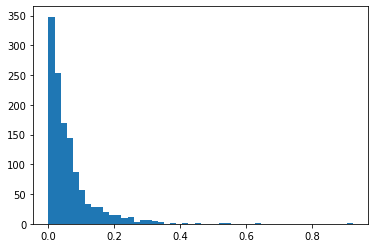

In [64]:
%matplotlib inline
hist(np.log10(relative_differences), bins=50)
print(min(relative_differences))

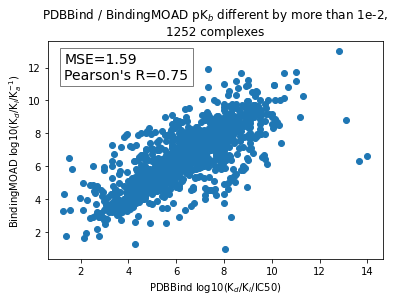

In [65]:
different_bks = np.array(different_bks)
scatter(different_bks[:, 0], different_bks[:, 1])
xlabel('PDBBind log10(K$_{d}$/K$_{i}$/IC50)')
ylabel('BindingMOAD log10(K$_{d}$/K$_{i}$/K$_a^{-1}$)')

title('PDBBind / BindingMOAD pK$_b$ different by more than 1e-2,\n{0} complexes'.format(len(different_bks)))


mse_ = mean_squared_error(different_bks[:, 0], different_bks[:, 1])
pearsonr_ = pearsonr(different_bks[:, 0], different_bks[:, 1])

# these are matplotlib.patch.Patch properties
props = dict(facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
text(0.05, 0.95, 'MSE={0:1.2f}\nPearson\'s R={1:1.2f}'.format(mse_, pearsonr_[0]), transform=gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

savefig('/home/maria/Pictures/pdbbind-bindingmoad-different.png', dpi=600)

In [68]:
# cofactors
for pdbcode in pdbcodes_both:
    pdbcode_cur = list(pdbbind_index[pdbcode].keys())[0]
    if len(bindingmoad_index[pdbcode]) > 1:
        has_cofactor = False
        for k in bindingmoad_index[pdbcode].keys():
            if k in ['NAD', 'NDH', 'NDP', 'ATP', 'GDP', 'GTP', 'ADP', 
                     'FMN', 'FAD', 'PLP', 'TTP', 'SAM', 'GSH', 'FMT', 
                     'UDP', 'UTP']:
                has_cofactor = True
#         if has_cofactor:
        print (pdbcode, pdbbind_index[pdbcode], bindingmoad_index[pdbcode])

1a4r {'GNH': ('Kd', '=', 0.22, 'uM', 6.657577319177793)} {'GDP': ('Kd', '=', 9.4e-06, 'uM', 11.0268721464003), 'GNH': ('Kd', '=', 0.22, 'uM', 6.657577319177793)}
1a7c {'THR ACE VAL ALA SER NH2': ('Kd', '<=', 100.0, 'uM', 4.0)} {'ACE THR VAL ALA SER SER NH2': ('Kd', '<', 100.0, 'uM', 4.0), 'THR ACE VAL ALA SER NH2': ('Kd', '<', 100.0, 'uM', 4.0)}
1abf {'FCA': ('Kd', '=', 3.8, 'uM', 5.42021640338319)} {'FCA': ('Kd', '=', 3.8, 'uM', 5.42021640338319), 'FCB': ('Kd', '=', 3.8, 'uM', 5.42021640338319)}
1apb {'FCB': ('Kd', '=', 1.51, 'uM', 5.82102305270683)} {'FCA': ('Kd', '=', 1.51, 'uM', 5.82102305270683), 'FCB': ('Kd', '=', 1.51, 'uM', 5.82102305270683)}
1apv {'IVA VAL DFO NME': ('Ki', '=', 0.001, 'uM', 9.0)} {'IVA VAL VAL DFO NME': ('Ki', '=', 0.001, 'uM', 9.0), 'IVA VAL DFO NME': ('Ki', '=', 0.001, 'uM', 9.0)}
1apw {'IVA VAL DFI NME': ('Ki', '=', 0.01, 'uM', 8.0)} {'IVA VAL VAL DFI NME': ('Ki', '=', 0.01, 'uM', 8.0), 'IVA VAL DFI NME': ('Ki', '=', 0.01, 'uM', 8.0)}
1aqc {'GLY TYR GLU ASN

In [67]:
# tests
print(np.isclose(0.13, 0.009, rtol=10))
print(0.13/0.009)
print(np.isclose(4.585026652029182, 4.6020599913279625, atol=0.01))

False
14.444444444444446
False
